In [28]:
from __future__ import division

from past.utils import old_div

# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *

import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles

from scipy.io import savemat

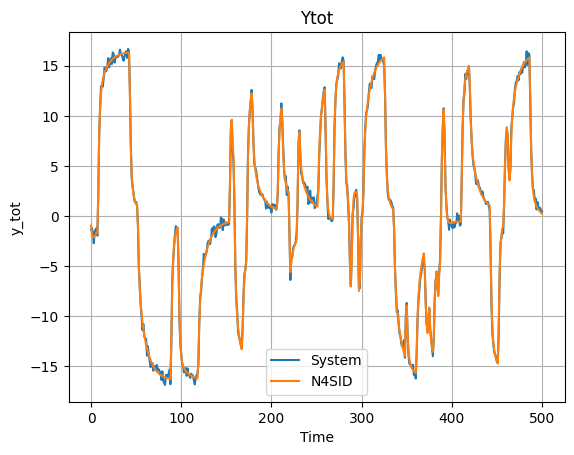

In [35]:
"""
Created on Fri Jan 19 2018
@author: Giuseppe Armenise, revised by RBdC
In this test, no error occurs. 
Using method='N4SID','MOESP' or 'CVA', if the message
"Kalman filter cannot be calculated" is shown, it means
that the package slycot is not well-installed.
"""



# Example to test SS-methods

# sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.], [0., 0.45]])
B = np.array([[0.3, 0.7], [2.5, 1.4]])
C = np.array([[0.7, 1.]])
D = np.array([[2.0, 1.0]])

tfin = 500
npts = int(old_div(tfin, ts)) + 1
Time = np.linspace(0, tfin, npts)
m = 2

# Input sequence
U = np.zeros((m, npts))
for i in range(m):
    [U[i, :],_,_] = fset.GBN_seq(npts, 0.05)

##Output
x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# measurement noise
noise = fset.white_noise_var(npts, [0.15])

# Output with noise
y_tot = yout + noise

#
# plt.figure(0)
# plt.plot(Time, U[0])
# plt.ylabel("input")
# plt.grid()
# plt.xlabel("Time")
#
plt.figure()
plt.plot(Time, y_tot[0])
plt.ylabel("y_tot")
plt.grid()
plt.xlabel("Time")
plt.title("Ytot")

##System identification
METHOD = ['N4SID']
lege = ['System']
for i in range(len(METHOD)):
    method = METHOD[i]
    sys_id = system_identification(y_tot, U, method, SS_D_required=True, SS_fixed_order = 2 )
    xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0)
    #
    plt.plot(Time, yid[i])
    lege.append(method) 
    
plt.legend(lege) 

In [36]:
print(sys_id.D)
print(D)

[[1.91477296 0.94412245]]
[[2. 1.]]


In [16]:
# Load real data
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1 - np.nonzero(y)[1][np.newaxis]
inputs = np.load('../data/real-data/d2mice_inputs.npy')

In [17]:
# Set up system parameters
p = 3
m = 4
k = 30
u = np.hstack((inputs[:,0:2],inputs[:,-2:])).T

# Fit
sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k)

In [18]:
print(y.shape)

(1, 54883)


In [ ]:
np.set_printoptions(suppress=True, precision=4)
print(sys_id.A)
print(sys_id.B)
print(sys_id.C)
print(sys_id.D)

In [ ]:
plt.figure()
plt.plot(y[0, :], label='true')
# plt.xlim()
xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, u, sys_id.x0)
plt.plot(yid[0, :], label='sippy');
plt.legend()

In [ ]:
print(y_tot.shape) # Output shape from their example
print(U.shape)     # Input shape from their example

print(y.shape)     # Our data
print(u.shape)

print(yid.shape)   # Shape of the predicted outputs

In [ ]:
np.savez('./fit_params/sippy_gausslds_fit.npz', Ahat=sys_id.A, Bhat=sys_id.B, Chat=sys_id.C, Dhat=sys_id.D)

## Model comparison

In [ ]:
d = np.load('../data/model-comparisons/datasetB/datasetB_large.npz')

# for key in d.keys():
#     print(key)
    
u_train = d['u_train']
y_train = d['y_train']
u_test = d['u_test']
y_test = d['y_test']

A = d['A']

In [ ]:
num_folds = 5
m = u_train.shape[-1]
q = y_train.shape[-1]
p = A.shape[0]

for fold in range(num_folds):
    print(fold)
    u = u_train[fold, :, :].T
    y = y_train[fold, :, :].T
    
#     print(u.shape)
#     print(y.shape)
    sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p)
    
    savemat('./model-comparison-fits/datasetB_large_gaussian_fold%d.mat' % fold, {'Ahat':sys_id.A, 
             'Bhat':sys_id.B, 'Chat':sys_id.C, 'Dhat':sys_id.D,
             'u_train':u_train, 'u_test':u_test, 'y_train':y_train, 'y_test':y_test,
             'A':d['A'], 'B':d['B'], 'C':d['C'], 'D':d['D'], 'Q':d['Q'], 'N':d['N']})

## Real data

In [ ]:
# Load real data
d = np.load('../data/real-data/baseline-performance/train_test_info.npz', allow_pickle=True)

for key in d.keys():
    print(key)
    
y_train = d['y_train']
y_test = d['y_test']
u_train = d['u_train']
u_test = d['u_test']
sessions_train = d['sessions_train']
sessions_test = d['sessions_test']
trials_test = d['trials_test']
seeds = d['seeds']

p = 3
m = 4
k = 30
q = 1
nfolds = 5
# y = 1 - np.nonzero(y)[1][np.newaxis]
# inputs = np.load('../data/real-data/d2mice_inputs.npy')

In [ ]:
A = np.zeros((nfolds, p, p))
B = np.zeros((nfolds, p, m))
C = np.zeros((nfolds, q, p))
D = np.zeros((nfolds, q, m))
Q = np.zeros((nfolds, p, p))

for fold in range(5):
    u = u_train[fold].T
    y = y_train[fold].T
    sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k)
    
    A[fold, :, :] = sys_id.A
    B[fold, :, :] = sys_id.B
    C[fold, :, :] = sys_id.C
    D[fold, :, :] = sys_id.D
    Q[fold, :, :] = sys_id.Q
    
param_dict = {'A' : A, 'B' : B, 'C' : C, 'D' : D, 'Q' : Q, 'y_train' : y_train, 'y_test' : y_test,
              'u_train' : u_train, 'u_test' : u_test, 'sessions_train' : sessions_train, 
              'sessions_test' : sessions_test, 'trials_test' : trials_test, 'seeds' : seeds}
savemat('../data/real-data/baseline-performance/gaussian_train_params.mat', param_dict)
    

## EM

In [ ]:
import scipy.io as sio

for i in range(7):
    # Load real data
    d = np.load('../data/em-inits/datasetD_q1/best-lds-%d.npz' % i)
    y = d['y']
    u = d['u']
    p = d['A'].shape[0]
    k = p
    
    sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k)
    np.savez('../data/em-inits/datasetD_q1/gaussian-%d.npz' % i, Ahat=sys_id.A, Bhat=sys_id.B, 
             Chat=sys_id.C, Dhat=sys_id.D, Qhat=sys_id.Q, seed=d['seed'], A=d['A'], B=d['B'], C=d['C'], 
             C_new=d['C_new'], D=d['D'], Q=d['Q'], Q0=d['Q0'], x0=d['x0'], muu=d['muu'], 
             Qu=d['Qu'], y=y, z=d['z'], u=u, x=d['x'])
    
    data_dict = {}
    for key in d.keys():
        data_dict[key] = d[key]
        
    data_dict['Ahat'] = sys_id.A
    data_dict['Bhat'] = sys_id.B
    data_dict['Chat'] = sys_id.C
    data_dict['Dhat'] = sys_id.D
    data_dict['Qhat'] = sys_id.Q
    
#     sio.savemat('data/em-inits/datasetD_q1/gaussian-%d.mat' % i, data_dict)

## Fig2, N4SID on $z$

In [37]:
import sys
 
# setting path
sys.path.append('../')

# Import our functions
from moment_conversion import *
from ssid import *
from simulate import *

# Import other things that might be useful
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import subspace_angles
import scipy.io as sio
import pickle

In [13]:
d = np.load('../err_metrics/fig2_unitized.npz', allow_pickle=True)

for key in d.keys():
    print(key)

print(d['C_news'].shape)

A
B
C
C_news
D
Q
Q0
x0
muu
Qu
ys
zs
us
xs
Ahats
Bhats
Chats
Dhats
Aangles
Cangles
Dangles
Gangles
(9, 30, 1, 10, 5)


In [38]:
### Simulation with driven LDS-BEST
seed = 8656
np.random.seed(seed) # 8656 # 9347

## System orders
q = 10 # dimension of the data
p = 5  # dimension of the state space
ks = [10] # Hankel parameter
m = 3

## Specific system parameters
# System parameters

A = generate_dynamics_matrix(p, eig_high = 0.99, eig_low = 0.9)
B = generate_input_matrix(p,m) * .1
D = generate_input_matrix(q,m) * .1
Q = np.eye(p) * .1
gamma = np.eye(q) * .1
d = np.zeros(q)

noise = np.random.standard_normal(size=(q,p))
U,_,_ = np.linalg.svd(noise,full_matrices=False)
C = U

# M = np.random.uniform(0,1,size=(q,p))
# C,rr = np.linalg.qr(M)

# Prior parameters
x0 = np.zeros(p)
Q0 = np.eye(p) * .1

# Inputs
muu = np.zeros(m)
Qu = np.eye(m) * 2

### Simulation parameters
Ns = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]
num_sims = 30

# Storage variables
Aangles = np.zeros((len(Ns), num_sims, len(ks))) # Mean difference in the sorted eigenvalues
Cangles = np.zeros((len(Ns), num_sims, len(ks))) # Subspace angle between true C and inferred C
Dangles = np.zeros((len(Ns), num_sims, len(ks))) # Reconstruction error between true D and inferred D
Gangles = np.zeros((len(Ns), num_sims, len(ks))) # Reconstruction error in the gain matrix

sip_Aangles = np.zeros((len(Ns), num_sims, len(ks))) # Mean difference in the sorted eigenvalues
sip_Cangles = np.zeros((len(Ns), num_sims, len(ks))) # Subspace angle between true C and inferred C
sip_Dangles = np.zeros((len(Ns), num_sims, len(ks))) # Reconstruction error between true D and inferred D
sip_Gangles = np.zeros((len(Ns), num_sims, len(ks))) # Reconstruction error in the gain matrix

C_news = np.zeros((len(Ns), num_sims, len(ks), q, p))

ys = np.empty((len(Ns), num_sims), dtype=object)
xs = np.empty((len(Ns), num_sims), dtype=object)
us = np.empty((len(Ns), num_sims), dtype=object)
zs = np.empty((len(Ns), num_sims), dtype=object)

Ahats = np.zeros((len(Ns), num_sims, p, p))
Bhats = np.zeros((len(Ns), num_sims, p, m))
Chats = np.zeros((len(Ns), num_sims, q, p))
Dhats = np.zeros((len(Ns), num_sims, q, m))

sip_Ahats = np.zeros((len(Ns), num_sims, p, p))
sip_Bhats = np.zeros((len(Ns), num_sims, p, m))
sip_Chats = np.zeros((len(Ns), num_sims, q, p))
sip_Dhats = np.zeros((len(Ns), num_sims, q, m))

# True derived variables
true_A_eigs = np.sort(np.linalg.eig(A)[0])

# Run simulations
for ndx, N in enumerate(Ns):
    print('N: ', N)
    for kdx, k in enumerate(ks):
        print('\tK: ', k)
        for sim in range(num_sims):
            print('\t\t sim #: ', sim)
        
            # Get initial diag z for unitizing
            u = np.random.multivariate_normal(muu,Qu,size=N)
            y, x, u, z, _ = simulate_driven_bernoulli_lds(N,x0,Q0,A,B,Q,C,D,d,muu,Qu,inputs=u)#,R=gamma)

            z_reshaped = future_past_Hankel_order_stream(z, k, q, flip=True)
            sig_z = np.cov(z_reshaped)[: q, q : 2*q]
            diag_z = np.diag(sig_z)
        
            # Resimulate with unitizing data
            y, x, u, z, C_new = simulate_driven_bernoulli_lds(N,x0,Q0,A,B,Q,C,D,d,muu,Qu,diag_z=diag_z,inputs=u)#,R=gamma)

            # Store
            ys[ndx, sim] = y
            xs[ndx, sim] = x
            us[ndx, sim] = u
            zs[ndx, sim] = z
            
            # moment conversion
            y_reshaped = future_past_Hankel_order_stream(y, k, q).T
            u_reshaped = future_past_Hankel_order_stream(u, k, m).T
            mu_zs, mu_us, sigma_zz, sigma_uu, sigma_zu = fit_mu_sigma_bernoulli_driven(y_reshaped, u_reshaped)

            # rearrange sigma, get estimate of covariance w 
            sigma_zz_full = tril_to_full(sigma_zz, 2 * k * q)
            sigma_what = get_sigmaw_driven(sigma_uu, sigma_zz_full, sigma_zu)

            # cholesky decompose R
            R = get_R(sigma_what)

            # run n4sid
            Ahat,Bhat,Chat,Dhat,_,_,_,ss = driven_n4sid(R,k,m,p,q)
            
            # Store
            Ahats[ndx, sim, :, :] = Ahat
            Bhats[ndx, sim, :, :] = Bhat
            Chats[ndx, sim, :, :] = Chat
            Dhats[ndx, sim, :, :] = Dhat

            # Get error of A
            est_A_eigs = np.sort(np.linalg.eig(Ahat)[0])
            Aangles[ndx, sim, kdx] = np.mean(np.abs(true_A_eigs - est_A_eigs))

            # Get error of C
            Cangles[ndx,sim,kdx] = subspace_angles(C_new,Chat)[0] # subspace angle

            # Get error of D
            Dangles[ndx,sim,kdx] = np.mean(np.abs(D - Dhat))

            # Get gain error
            true_gain = C_new @ np.linalg.inv(np.eye(p) - A) @ B + D
            est_gain = Chat @ np.linalg.inv(np.eye(p) - Ahat) @ Bhat + Dhat
            Gangles[ndx, sim, kdx] = np.mean(np.abs(est_gain - true_gain))
            
            # Fit sippy directly on zs and compute errors
            print('\t\t Identifying system')
            sys_id = system_identification(z.T, u, 'N4SID', SS_D_required=True, SS_fixed_order = p, SS_f = k)
            sip_Ahat, sip_Bhat, sip_Chat, sip_Dhat = sys_id.A, sys_id.B, sys_id.C, sys_id.D
            
            sip_Ahats[ndx, sim, :, :] = sip_Ahat
            sip_Bhats[ndx, sim, :, :] = sip_Bhat
            sip_Chats[ndx, sim, :, :] = sip_Chat
            sip_Dhats[ndx, sim, :, :] = sip_Dhat
            
            print('\t\t A error')
            est_A_eigs = np.sort(np.linalg.eig(sip_Ahat)[0])
            sip_Aangles[ndx, sim, kdx] = np.mean(np.abs(true_A_eigs - est_A_eigs))

            # Get error of C
            print('\t\t C error')
            sip_Cangles[ndx,sim,kdx] = subspace_angles(C_new,sip_Chat)[0] # subspace angle

            # Get error of D
            print('\t\t D error')
            sip_Dangles[ndx,sim,kdx] = np.mean(np.abs(D - sip_Dhat))

            # Get gain error
            print('\t\t G error')
            true_gain = C_new @ np.linalg.inv(np.eye(p) - A) @ B + D
            est_gain = sip_Chat @ np.linalg.inv(np.eye(p) - sip_Ahat) @ sip_Bhat + sip_Dhat
            sip_Gangles[ndx, sim, kdx] = np.mean(np.abs(est_gain - true_gain))
            
            # Save C_new
            C_news[ndx, sim, kdx, :, :] = C_new
            
            
            
        # Intermediate storage in case everything crashes woop woop
        np.savez('../err_metrics/fig2_unitized.npz', A=A, B=B, C=C, C_news=C_news, D=D, 
                 Q=Q, Q0=Q0, x0=x0,muu=muu, Qu=Qu, 
                 ys=ys, zs=zs, us=us, xs=xs, Ahats=Ahats, Bhats=Bhats, Chats=Chats, Dhats=Dhats,
                 Aangles=Aangles, Cangles=Cangles, Dangles=Dangles, Gangles=Gangles,
                 sip_Ahats=sip_Ahats, sip_Bhats=sip_Bhats, sip_Chats=sip_Chats, sip_Dhats=sip_Dhats,
                 sip_Aangles=sip_Aangles, sip_Cangles=sip_Cangles, sip_Dangles=sip_Dangles, 
                 sip_Gangles=sip_Gangles)
        
        
        
        

N:  1000
	K:  10
		 sim #:  0
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  2


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.52709e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  4


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.50646e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  5


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.3904e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  6


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.04521e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  7


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.13929e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  8


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.01654e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  9


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.69184e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  12


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.49971e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  13


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.8247e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  14


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.02117e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  16


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.31171e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  17


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.4539e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  18


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.79747e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  19


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.99432e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  20


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.32319e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  21


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.24944e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  22


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.8836e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  23


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.88177e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  24


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.18673e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  25


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.67859e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  26


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.972e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  27


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.11355e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  28


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.52253e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system
		 A error
		 C error
		 D error
		 G error


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.56852e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


N:  2000
	K:  10
		 sim #:  0
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  1


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.74824e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  2


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.10858e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  3


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.30007e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  4


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.29553e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  5


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.28339e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  6


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.58898e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  7


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.43784e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  8


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.36076e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  9


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.29671e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  10


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.35672e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  11


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.05966e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  12


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.44273e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  13


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.33655e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  14


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.30724e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  16


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.94017e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  17


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.34694e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  19


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.51327e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  20


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.18046e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  21


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.65648e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  23


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.31001e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  26


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.46247e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  27


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.72225e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  28


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.6583e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  29


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.96385e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
N:  4000
	K:  10
		 sim #:  0


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.10199e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  1


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.30726e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  2


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.11772e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  3


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.4194e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  4


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.92722e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  5


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.50059e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  7


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.52235e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  8


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.55551e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  9


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.91225e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  10


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.8268e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  11


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.03312e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  12


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.00583e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  13


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.2106e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  14


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.26424e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  15


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.48859e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  16


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.29628e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  17


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.3963e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  18


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.72424e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  20


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.98236e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  21


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.718e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  22


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.15886e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  23


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.95245e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  24


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.22179e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  25


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.19621e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  26


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.76383e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  27


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.29313e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
N:  8000
	K:  10
		 sim #:  0
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  1


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.15756e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  2


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.33909e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  3


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.04483e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  4


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.83156e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  6


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.20307e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  7


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.35865e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  8


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.95408e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  9


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.59912e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  10


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.48296e-20): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  11


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.46748e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  12


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.07229e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  13


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.35251e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  14


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.85303e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  15


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.16272e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  16


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.38886e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  17


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.10053e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  19


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.35484e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  21


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.01591e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  22


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.89761e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  23


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.29982e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  24


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.06297e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  25


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.13917e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  26


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.07203e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  27


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.25955e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
		 A error
		 C error
		 D error
		 G error
		 sim #:  28


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.00369e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system
		 A error
		 C error
		 D error
		 G error


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.18368e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


N:  16000
	K:  10
		 sim #:  0
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.82457e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.40226e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  2
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.30077e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.67211e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  4
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.07925e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.46121e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  7
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  8
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.89269e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  9
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.75618e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.04423e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  12
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.05505e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  13
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  14
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.32827e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.71449e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  16
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.40486e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  17
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.0433e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.29621e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.73678e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.1711e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  21
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.49972e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.10593e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  23
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.52395e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.48014e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.60903e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  26
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.66157e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  27
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.1504e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.75719e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
N:  32000
	K:  10
		 sim #:  0
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.19456e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  2
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.13713e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  4
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.95905e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.46282e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.26348e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  7
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.05123e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  8
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.3972e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  9
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.20564e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.26975e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.56839e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  12
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.22143e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  13
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.11058e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  14
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.84609e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.1852e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  16
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.83229e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  17
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.2644e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.16469e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.73168e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.66602e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  21
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.66565e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.38166e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  23
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.32964e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.44761e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.53938e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  26
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.54357e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  27
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.61675e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.94015e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.49973e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
N:  64000
	K:  10
		 sim #:  0
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.6007e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.45998e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  2
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.20242e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.46135e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  4
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.94131e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.58193e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.7363e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  7
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.29577e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  8
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.30973e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  9
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.17625e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.74105e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.51957e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  12
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.58766e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  13
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.28948e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  14
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.54516e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.97773e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  16
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.61355e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  17
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.46582e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.11836e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.22019e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  21
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.09908e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.72374e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  23
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.47045e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.40036e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.61429e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  26
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.987e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  27
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.99119e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.34345e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
N:  128000
	K:  10
		 sim #:  0
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.07961e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.09106e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  2
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.50021e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.06004e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  4
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.91511e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.3468e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.60389e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  7
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.23656e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  8
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.09465e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  9
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.09455e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.43017e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.35835e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  12
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.95428e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  13
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.10741e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  14
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.16002e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.32464e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  16
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.85535e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  17
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.5188e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.25201e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.20038e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.68929e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  21
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.91408e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=9.29282e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  23
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.93618e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.35037e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  26
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.79542e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  27
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.02214e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.23072e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
N:  256000
	K:  10
		 sim #:  0
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.16403e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  1
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.27792e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  2
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.04402e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  3
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  4
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.49454e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  5
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.75048e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  6
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.03012e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  7
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.42635e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  8
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.13444e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  9
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=4.26326e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  10
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.06932e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  11
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.5892e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  12
		 Identifying system
Kalman filter cannot be calculated
		 A error
		 C error
		 D error
		 G error
		 sim #:  13
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.6274e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  14
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.35973e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  15
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.15254e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  16
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.71423e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  17
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.74089e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  18
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=3.16562e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  19
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=5.63501e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  20
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=8.10875e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  21
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=7.83973e-19): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  22
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.79158e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  23
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.14867e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  24
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=6.09837e-18): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  25
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.07573e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  26
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.57e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  27
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.76428e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  28
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=1.07422e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error
		 sim #:  29
		 Identifying system


/opt/anaconda3/envs/bestLDS/lib/python3.10/site-packages/control/mateqn.py:600: LinAlgWarning: Ill-conditioned matrix (rcond=2.38076e-17): result may not be accurate.
  G = solve(B.T @ X @ B + R, B.T @ X @ A + S.T)


		 A error
		 C error
		 D error
		 G error


In [21]:
z.shape

(1000, 10)